# Implementing a Neural Network from Scratch in Python


### This notebook will implement a simple 3-layer neural network from scratch


Basic knowledge of Calculus, Machine Learning concepts and optimization techniques will be helpful to gain a full understanding of how neural networks work.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='white')
%matplotlib inline

## Generating a dataset

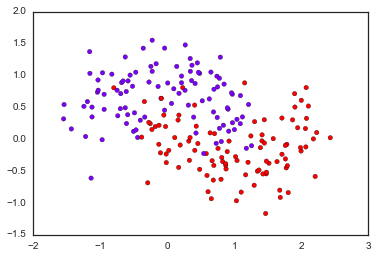

In [85]:
from sklearn import datasets
np.random.seed(0)
X, y = datasets.make_moons(n_samples=200, noise=0.3)
plt.scatter(X[:,0],X[:,1], s=20, c = y, cmap=plt.cm.rainbow);

The goal is to train a model using Machine Learning techniques that is able to separate accurately the two classes (purple and red).

## Logistic Regression

Let's see what a simple logictic regression can do for us.

In [33]:
from sklearn import linear_model
logit = linear_model.LogisticRegression()
logit.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [34]:
# Helper function to plot a decision boundary.

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.rainbow)

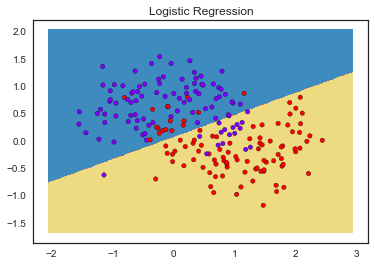

In [35]:
plot_decision_boundary(lambda x: logit.predict(x))
plt.title("Logistic Regression");

In [36]:
print "Accuracy: ",logit.score(X,y)

Accuracy:  0.835


With an accuracy of 87%, the logistic regression model was able to some extent differentiate the classes. However, from the plot we can observe that it was not able to capture the true wavy pattern in the data. In fact, unless we engineer specific non-linear features, a logistic regression model can only produce a linear decision boundary. 

What we need is a model that is able to engineer its own non-linear features.

## Training a Neural Network

** Model Architecture**

Let’s now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also.

![](image/neural_net.jpeg)

**Hidden Layer**

What we can choose is the number  of nodes we want to have in the hidden layer. The higher the size of this layer, the more complex functions the model will be able to aproximate. This is exactly what we will need to obtain the non-linear decicsion boundary for the data.

However higher dimensionality also has its drawbacks:
* higher computation for training
* risk of overfitting data

Because of this tradeoff it is not always obvious what the size of the hidden layer should be. In this notebook we will expermiment with different number of nodes in the hidden later and see how it affects our decicsion boundary.

** Activation Function**

The hidden nodes use an activation function to apply a transformation to the data. These functions are non-linear and make it possible to represent the data in terms of non-linear  features. In this notebook, we will use the tanh function as the activation function. Other popular functions are the sigmoid function or ReLUs. 

The activation function of the output layer is the softmax function. This function takes a score and transforms it into a probability. It is a generalization of the logistic regression for multiple classes

In [37]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

In [38]:
def calculate_loss(model):
    """
    function to evaluate the total loss on the dataset
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [39]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [40]:
from collections import defaultdict

def build_model(nn_hdim, num_passes=5000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'loss': []}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        
        # Assign new parameters to the model
        model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            loss = calculate_loss(model)
            model['loss'].append(loss)
            print "Loss after iteration %i: %f" %(i, loss)
            
    
    return model

Loss after iteration 0: 0.450604
Loss after iteration 1000: 0.198825
Loss after iteration 2000: 0.194960
Loss after iteration 3000: 0.193785
Loss after iteration 4000: 0.193277
Accuracy:  0.925


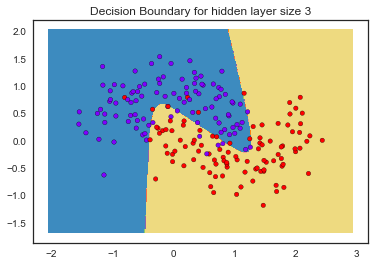

In [41]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3");

print "Accuracy: ",np.mean(predict(model, X) == y)

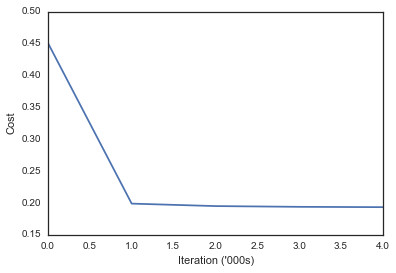

In [42]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('000s)")
plt.ylabel("Cost")
plt.show()

In [86]:
np.random.seed(2)
X_test, y_test = datasets.make_moons(n_samples=200, noise=0.4)

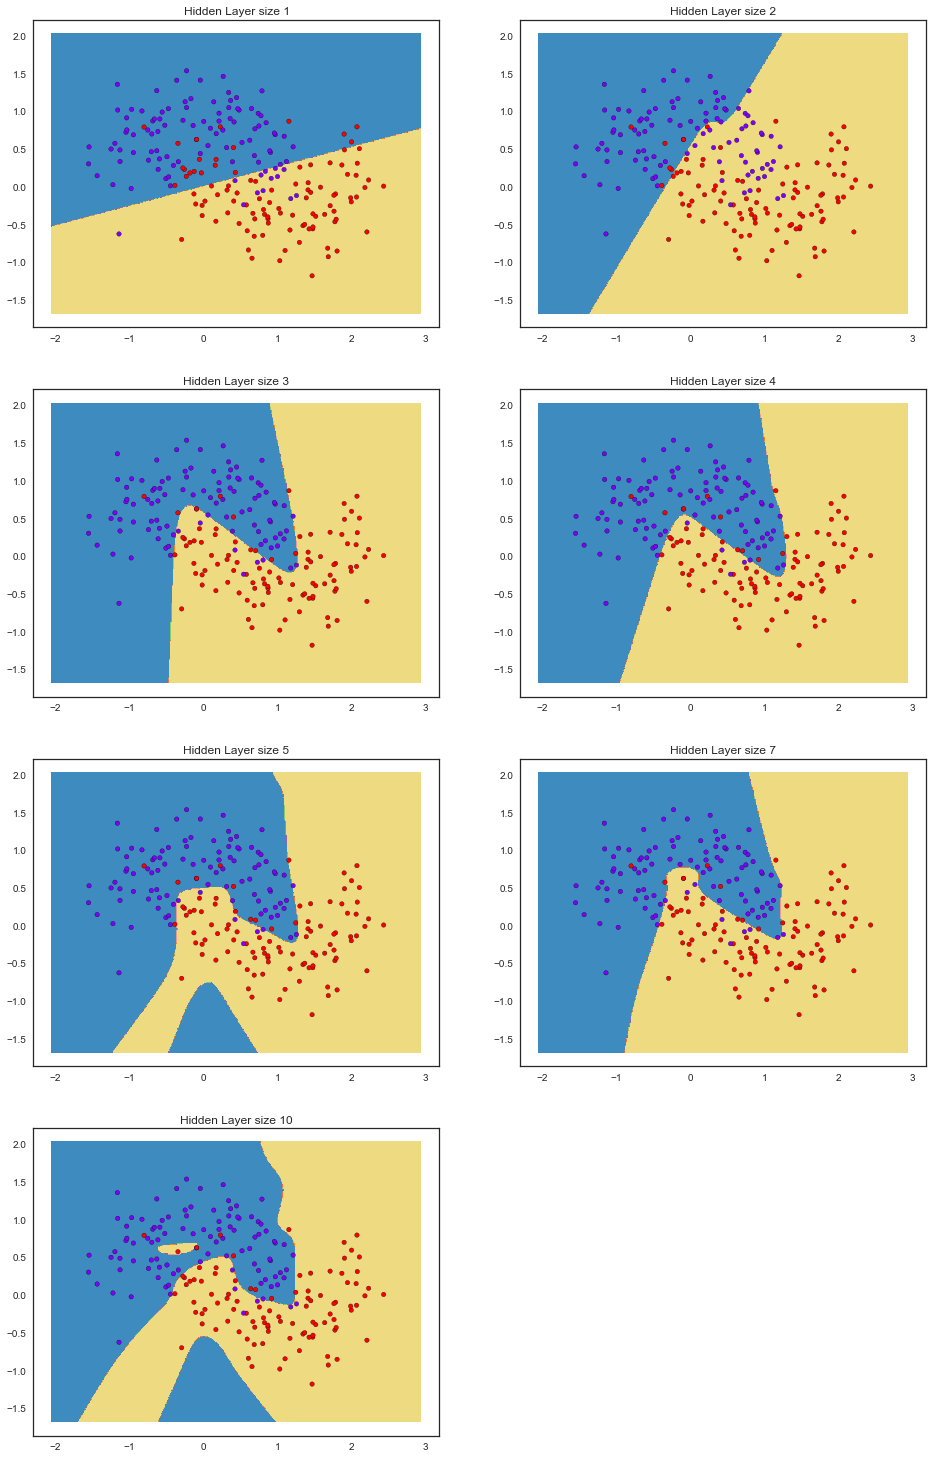

In [87]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 7, 10]

train_error = []
test_error = []
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    
    train_error.append(1 - np.mean(predict(model, X) == y))
    test_error.append(1 - np.mean(predict(model, X_test) == y_test))
    
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

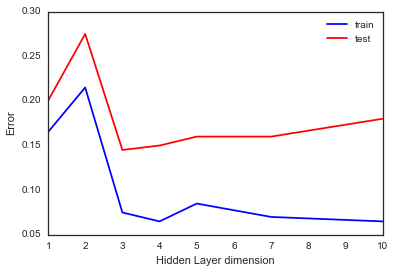

In [88]:
plt.plot(hidden_layer_dimensions, train_error, c = 'b')
plt.plot(hidden_layer_dimensions, test_error , c = 'r')
plt.xlabel("Hidden Layer dimension")
plt.ylabel("Error")
plt.legend(['train', 'test'])
plt.show()

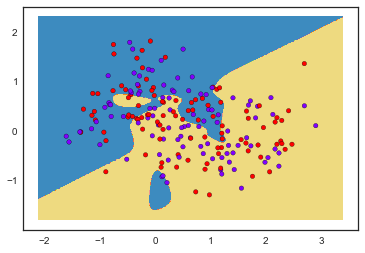

In [89]:
model = build_model(50, print_loss=False)
X = X_test
plot_decision_boundary(lambda x: predict(model, x))

In [80]:
print model["W1"].shape
print X.shape
print X_test.shape

(2, 50)
(200, 2)
(200, 2)


In [52]:
whos

Variable                  Type                  Data/Info
---------------------------------------------------------
X                         ndarray               200x2: 400 elems, type `float64`, 3200 bytes
X_test                    ndarray               200x2: 400 elems, type `float64`, 3200 bytes
build_model               function              <function build_model at 0x114ac7e60>
calculate_loss            function              <function calculate_loss at 0x11565ea28>
datasets                  module                <module 'sklearn.datasets<...>n/datasets/__init__.pyc'>
defaultdict               type                  <type 'collections.defaultdict'>
epsilon                   float                 0.01
hidden_layer_dimensions   list                  n=7
i                         int                   6
linear_model              module                <module 'sklearn.linear_m<...>near_model/__init__.pyc'>
logit                     LogisticRegression    LogisticRegression(C=1.0,<...>0